## A minimalist example for recovering sparse graphs using `uGLAD`

Fitting uGLAD on a erdos-renyi random sparse graph with samples obtained from a corresponding multivariate Gaussian distribution.    

### About `uGLAD` 
Sparse graph recovery by optimizing deep unrolled networks. This work proposes `uGLAD` which is a unsupervised version of a previous `GLAD` model (GLAD: Learning Sparse Graph Recovery (ICLR 2020 - [link](<https://openreview.net/forum?id=BkxpMTEtPB>)).  

Key benefits & features:  
- Solution to Graphical Lasso: A better alternative to solve the Graphical Lasso problem as
    - The neural networks of the uGLAD enable adaptive choices of the hyperparameters which leads to better performance than the existing algorithms  
     - No need to pre-specify the sparsity related regularization hyperparameters    
    - Requires less number of iterations to converge due to neural network based acceleration of the unrolled optimization algorithm (Alternating Minimization)    
    - GPU based acceleration can be leveraged  
    - Novel `consensus` strategy which robustly handles missing values by leveraging the multi-task learning ability of the model   
    - Multi-task learning mode that solves the graphical lasso objective to recover multiple graphs with a single `uGLAD` model  
- Glasso loss function: The loss is the logdet objective of the graphical lasso `1/M(-1*log|theta|+ <S, theta>)`, where `M=num_samples, S=input covariance matrix, theta=predicted precision matrix`.  
- Ease of usability: Matches the I/O signature of `sklearn GraphicalLassoCV`, so easy to plug-in to the existing code.  

In [1]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# install jupyter-notebook in the env if the prefix does not 
# show the desired virtual env. 
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/anaconda3/envs/uGLAD


In [2]:
# Install the uGLAD package if it is not already installed
# ! pip install uglad
import torch
torch.__version__

'2.7.1'

# 1. Synthetic data convergence

In [3]:
from uglad.utils.prepare_data import get_data
from uglad.utils.metrics import report_metrics_all

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = get_data(
    num_nodes=20, 
    sparsity=[0.2, 0.2], 
    num_samples=500, 
    batch_size=1,
    eig_offset=1, 
    w_min=0.5,
    w_max=1
)
print(f'true_theta: {true_theta.shape}, Samples {Xb.shape}')

true_theta: (1, 20, 20), Samples (1, 500, 20)


### The uGLAD model

Learning details:  
1. Initialize learnable `GLAD` parameters  
2. Run the GLAD model  
3. Get the glasso-loss  
4. Backprop  

Possible solutions if `uGLAD` does not converge:  
1. Increase number of training EPOCHS
2. Lower the learning rate    
3. Please re-run. This will run the optimization with different initializations  
4. Change the INIT_DIAG=0/1 in the `GLAD` model parameters  
5. Increase `L`, the number of unrolled iterations of `GLAD`

### Running the uGLAD-Direct mode

- Directly optimize the uGLAD model on the complete data X
- Optimizes the model to minimize the glasso-loss on X 

Running uGLAD
Processing the input table for basic compatibility check
: Processing the input table for basic compatibility check
: The input table has sample 500 and features 20
: Total zero samples dropped 0
: Single value columns dropped:            total 0, columns []
Input covariance matrix: The condition number 8.437591765567518 and min eig 0.008088754290042006 max eig 0.06824960659135737
: Duplicates dropped:                total 0, columns []
: Low Variance columns dropped: min variance 0.0,        total 0, columns []
Processed covariance matrix: The condition number 8.437591765567518 and min eig 0.008088754290042011 max eig 0.06824960659135741
: The processed table has sample                500 and features 20
: Total time to process the table 0.028 secs
Direct Mode
Initialized parameters for uGLAD theta_init_offset=1.0,nF=3,H=3
epoch:0/800 loss:-24.19041633605957
epoch:80/800 loss:-34.01111602783203
epoch:160/800 loss:-38.15787887573242
epoch:240/800 loss:-41.55694580078125
e

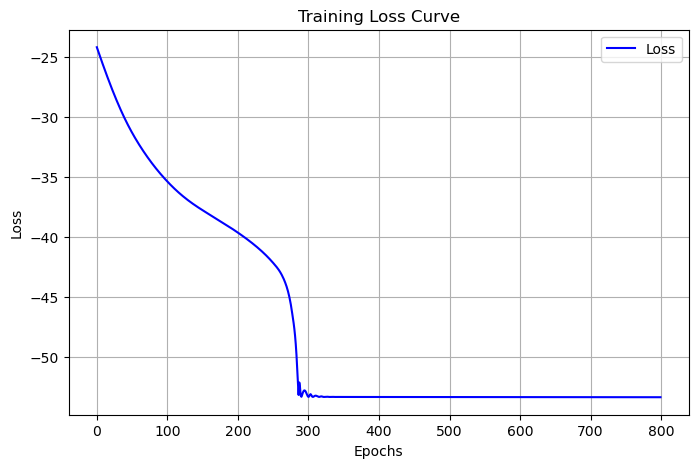

Total runtime: 14.827335119247437 secs

uGLAD: {'FDR': 0.521, 'TPR': 1.0, 'FPR': 0.245, 'SHD': 38.0, 'nnzTrue': 35.0, 'nnzPred': 73.0, 'precision': 0.479, 'recall': 1.0, 'Fbeta': 0.648, 'aupr': 0.994, 'auc': 0.999}


In [4]:
from uglad import main as uG

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

# Fit to the data
model_uGLAD.fit(
    Xb[0],
    centered=False,
    epochs=800,
    lr=0.002,
    INIT_DIAG=0,
    L=15,
    verbose=True, #False, 
    k_fold=0,  # Direct mode
    mode='direct'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = report_metrics_all(
        true_theta[0], 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

### Running the uGLAD-CV mode 

- Finds the best model by doing cross-fold validation on the input samples X
- Chooses the model which performs best in terms of glasso-loss on held-out data
- More conservative than the direct mode

In [ ]:
from uglad import main as uG

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

# Fit to the data
model_uGLAD.fit(
    Xb[0],
    centered=False,
    epochs=800,
    lr=0.002,
    INIT_DIAG=0,
    L=15,
    verbose=False,
    k_fold=5, 
    mode='cv'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = report_metrics_all(
        true_theta[0], 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
CV mode: 5-fold
Total runtime: 93.86193203926086 secs

uGLAD: {'FDR': 0.558, 'TPR': 1.0, 'FPR': 0.276, 'SHD': 43.0, 'nnzTrue': 34.0, 'nnzPred': 77.0, 'precision': 0.442, 'recall': 1.0, 'Fbeta': 0.613, 'aupr': 0.995, 'auc': 0.999}


### Comparison with sklearn's GraphicalLassoCV

In [14]:
from sklearn.covariance import GraphicalLassoCV

model_BCD = GraphicalLassoCV().fit(Xb[0])
# Compare with theta
compare_theta_BCD = report_metrics_all(
    true_theta[0], 
    model_BCD.precision_
)
print(f'BCD: {compare_theta_BCD}')

BCD: {'FDR': 0.58, 'TPR': 1.0, 'FPR': 0.301, 'SHD': 47.0, 'nnzTrue': 34.0, 'nnzPred': 81.0, 'precision': 0.42, 'recall': 1.0, 'Fbeta': 0.591, 'aupr': 0.995, 'auc': 0.999}


# 2. Handling missing values
Running `uGLAD` model in mode=`missing`:
- Leverages the multi-task learning feature of the `uGLAD` model
- Uses the novel `consensus` strategy to robustly handle the missing values

In [ ]:
# Adding dropout noise to Xb
from uglad.utils.prepare_data import add_noise_dropout
from uglad.main import mean_imputation
import numpy as np

# Adding np.NaNs to introduce missing values
Xb_miss = add_noise_dropout(Xb, dropout=0.83)
# Doing mean imputation for basic statistical comparsion
B, M, D = Xb_miss.shape
Xb_mean = [] 
for b in range(B):
    X_miss = Xb_miss[b].copy()
    X_miss = X_miss.reshape(1, M, D)
    Xb_mean.append(mean_imputation(X_miss).reshape(M, D))
Xb_mean = np.array(Xb_mean)

### Running the `uGLAD-miss` model in missing data mode 

In [ ]:
from uglad import main as uG

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

# Fit to the data
model_uGLAD.fit(
    Xb_miss[0],
    centered=False,
    epochs=500,
    lr=0.005,
    INIT_DIAG=0,
    L=15,
    verbose=False,
    k_fold=3,  # The number of sumsample splits
    mode='missing'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = report_metrics_all(
        true_theta[0], 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
Handling missing data
Creating K=3 row-subsampled batches
Getting the final precision matrix using the consensus strategy
Total runtime: 20.36613392829895 secs

uGLAD: {'FDR': 0.817, 'TPR': 0.824, 'FPR': 0.801, 'SHD': 131.0, 'nnzTrue': 34.0, 'nnzPred': 153.0, 'precision': 0.183, 'recall': 0.824, 'Fbeta': 0.299, 'aupr': 0.217, 'auc': 0.543}


### Missing values: Comparison with BCD-mean
Run GraphicalLassoCV with mean imputed Xb_mean

In [32]:
from sklearn.covariance import GraphicalLassoCV

model_BCD = GraphicalLassoCV().fit(Xb_mean[0])
# Compare with theta
compare_theta_BCD = report_metrics_all(
    true_theta[0], 
    model_BCD.precision_
)
print(f'BCD: {compare_theta_BCD}')

BCD: {'FDR': 0.5, 'TPR': 0.029, 'FPR': 0.006, 'SHD': 34.0, 'nnzTrue': 34.0, 'nnzPred': 2.0, 'precision': 0.5, 'recall': 0.029, 'Fbeta': 0.056, 'aupr': 0.188, 'auc': 0.511}


# 3. Multi-task learning mode
- Generate synthetic data coming from graphs with varying sparsity
- Recover the batch precision matrices for the batch input data X

In [ ]:
# Creating synthetic data for multi-task learning 
from uglad.utils.prepare_data import get_data
from uglad.utils.metrics import report_metrics_all

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = get_data(
    num_nodes=20, 
    sparsity=[0.1, 0.2], 
    num_samples=500, 
    batch_size=3,
    eig_offset=1, 
    w_min=0.5,
    w_max=1
)
print(f'true_theta: {true_theta.shape}, Samples {Xb.shape}')

true_theta: (3, 20, 20), Samples (3, 500, 20)


In [ ]:
# Running uGLAD in multi-task learning mode
from uglad import main as uG
from uglad.utils.metrics import summarize_compare_theta

# Initialize the model
model_uGLAD = uG.uGLAD_multitask()  

K = len(Xb)

# Fit to the data
model_uGLAD.fit(
    Xb,
    centered=False,
    epochs=200,
    lr=0.01,
    INIT_DIAG=0,
    L=15,
    verbose=False,
)

# Print the compare metrics
compare_theta_MT = []
for b in range(K):
    rM = report_metrics_all(
            true_theta[b], 
            model_uGLAD.precision_[b]
        )
    print(f'Metrics for graph {b}: {rM}\n')
    compare_theta_MT.append(rM)

# Calculate the average statistics
avg_results_MT = summarize_compare_theta(compare_theta_MT, method_name='uGLAD multi-task')

Running uGLAD in multi-task mode
Processing the input table for basic compatibility check
Total runtime: 8.207151889801025 secs

Metrics for graph 0: {'FDR': 0.702, 'TPR': 1.0, 'FPR': 0.552, 'SHD': 85.0, 'nnzTrue': 36.0, 'nnzPred': 121.0, 'precision': 0.298, 'recall': 1.0, 'Fbeta': 0.459, 'aupr': 0.999, 'auc': 1.0}

Metrics for graph 1: {'FDR': 0.748, 'TPR': 1.0, 'FPR': 0.512, 'SHD': 83.0, 'nnzTrue': 28.0, 'nnzPred': 111.0, 'precision': 0.252, 'recall': 1.0, 'Fbeta': 0.403, 'aupr': 1.0, 'auc': 1.0}

Metrics for graph 2: {'FDR': 0.703, 'TPR': 1.0, 'FPR': 0.535, 'SHD': 83.0, 'nnzTrue': 35.0, 'nnzPred': 118.0, 'precision': 0.297, 'recall': 1.0, 'Fbeta': 0.458, 'aupr': 0.993, 'auc': 0.999}

Avg results for uGLAD multi-task (mean, std)

{'FDR': (0.718, 0.021),
 'FPR': (0.533, 0.016),
 'Fbeta': (0.44, 0.026),
 'SHD': (83.667, 0.943),
 'TPR': (1.0, 0.0),
 'auc': (1.0, 0.0),
 'aupr': (0.997, 0.003),
 'nnzPred': (116.667, 4.19),
 'nnzTrue': (33.0, 3.559),
 'precision': (0.282, 0.021),
 'recall'